# Agreement between metrics and peer review in the UK REF

This notebook describes how to replicate the results of the citation analysis of the UK REF results, described in our paper [1]. We especially use this notebook to show how we obtain the bootstrapped results of the peer review uncertainty.

## Data analysis

We first load all the libraries needed for this notebook. We rely on `pandas` for handling all the data, and on `numpy` and `scipy` for matrix operations and statistical methods. Additionally, we load the local library `review` which implements all the details necessary for dealing with the peer review uncertainty. Finally, we use `matplotlib` for plotting.

In [1]:
import pandas as pd
pd.set_option('precision',2)
import numpy as np
import scipy
from review import ReviewModel

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_palette('Set1')

 We first read in all the necessary data.

In [2]:
df = pd.read_csv('indicators_2014.csv', sep=',', encoding='utf8')
df = df[pd.notnull(df['FourStar'])] # Only consider those who have non-null results
df['FourStar'] /= 100 # Define proportion of fourstars on a range of [0-1]

Let us have a brief look at the contents.

In [3]:
df.head(4)

,UKPRN,Institution,SortOrder,MainPanel,UOA,UnitOfAssessment,msubId,MultipleSubmission,JointSubmission,Profile,StaffFte,FourStar,ThreeStar,TwoStar,OneStar,Unclassified,n_submission,p,pp_top_prop
0,10000291,Anglia Ruskin University,10,A,3,"Allied Health Professions, Dentistry, Nursing ...",,NaN,NaN,Outputs,11.30,0.06,68.1,25.5,0.0,0.0,47,45,0.26
1,10000291,Anglia Ruskin University,10,A,4,"Psychology, Psychiatry and Neuroscience",,NaN,NaN,Outputs,13.70,0.10,61.5,25.6,2.6,0.0,39,35,0.14
2,10000291,Anglia Ruskin University,10,A,5,Biological Sciences,,NaN,NaN,Outputs,7.25,0.00,34.8,39.1,4.4,21.7,23,20,0.15
3,10000291,Anglia Ruskin University,10,B,15,General Engineering,,NaN,NaN,Outputs,8.00,0.00,31.0,65.6,3.4,0.0,29,16,0.47


The dataframe `df` contains on each row the institution (along with some details) and the unit of assessment (UOA) that was evaluated. Some institutions have multiple submissions (usually covering different topics). For each institution, the so-called *output* profile is listed, along with the proportions of outputs that are classified 1-4\*. Finally, the number of submitted outputs are specified (`n_submission`), as are the number of publications found in the WoS (`p`). The citation statistic used in the paper is called the PP(top 10%), here called the `pp_top_prop`, which is the proportion of the papers from the WoS that belong to the top 10% highest cited publications in their field.

The data on the REF results is provided by the REF itself, please see the documentation of the REF 2014 at http://results.ref.ac.uk/ for more information.

Let us now take a closer look at some of the correlations. To calculate size-dependent correlations we multiply the size-independent metrics by the number of papers.

In [4]:
df['FourStar_n'] = df['FourStar']*df['n_submission']
df['p_top_prop'] = df['pp_top_prop']*df['p']

We will first group by the unit of assessment in order to examine correlations.

In [5]:
grp_df = df.groupby(['UOA', 'UnitOfAssessment'])

We first consider size-independent correlations.

In [6]:
corr_size_indep = grp_df[['pp_top_prop', 'FourStar']].corr()
corr_size_indep = corr_size_indep.xs('FourStar', axis=0, level=2)['pp_top_prop']

Similarly, we can calculate size-dependent correlations.

In [7]:
corr_size_dep = grp_df[['p_top_prop', 'FourStar_n']].corr()
corr_size_dep = corr_size_dep.xs('FourStar_n', axis=0, level=2)['p_top_prop']

Let us put them side by side.

In [8]:
corr_df = pd.DataFrame({'size_independent': corr_size_indep, 
                        'size_dependent': corr_size_dep})
corr_df.sort_values('size_independent', ascending=False)

,,size_independent,size_dependent
UOA,UnitOfAssessment,,
18,Economics and Econometrics,0.89,0.95
1,Clinical Medicine,0.86,0.98
9,Physics,0.86,0.98
8,Chemistry,0.83,0.94
2,"Public Health, Health Services and Primary Care",0.83,0.98
7,Earth Systems and Environmental Sciences,0.80,0.93
4,"Psychology, Psychiatry and Neuroscience",0.79,0.96
13,"Electrical and Electronic Engineering, Metallurgy and Materials",0.77,0.91
5,Biological Sciences,0.69,0.98


This yields the empirical correlations reported in our paper.

We can also draw a scatter plot to get a better idea of how metrics compare to peer review. Let us take Physics for example.

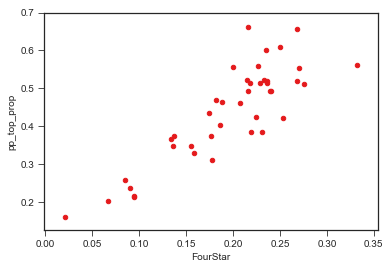

In [9]:
grp_df.get_group((9, 'Physics')).plot('FourStar', 'pp_top_prop', kind='scatter');

As explained in the paper, to get a better idea of the effects on funding when switching from peer review to metrics, we prefer to look at the median absolute difference (MAD) and median absolute percentage difference (MAPD). Defining it correctly involves a bit of work, because we need to calculate the predicted number of 4\* publications.

There are some technical details involved here. First, in regression we would usually use an intercept, but this is not appropriate in this case. In our context, having no top 10% publications should correspond to having no 4\* publications. Secondly, when both predicted and actual values are zero, the absolute percentage error is ill-defined: we choose to consider this as zero percent error. Finally, we need to estimate the parameter that determines how many top 10% publication translate into a 4\* publication. We simply do that based on the total number of top 10% and 4\* publications in a certain unit of analysis.

Let us first calculate the predicted values.

In [10]:
for (uoa, UnitOfAssesment), g in grp_df:
  df.loc[g.index, 'FourStar_n_predict'] = g['FourStar_n'].sum()/g['p_top_prop'].sum()*g['p_top_prop']

Now let us use this to calculate the MAPD for our size-dependent indicators.

In [11]:
def mapd(pred_y, y):
  diff_abs = np.abs(pred_y - y)
  diff = diff_abs/y
  diff[diff_abs==0] = 0
  return np.median(diff)

mapd_df = grp_df.apply(lambda grp: mapd(grp['FourStar_n_predict'], grp['FourStar_n']))

# Now also inlude the previously calculcated mapd
corr_df = pd.DataFrame({'size_independent': corr_size_indep, 
                        'size_dependent': corr_size_dep,
                        'mapd': mapd_df})
                        
corr_df.sort_values('mapd')

,,size_independent,size_dependent,mapd
UOA,UnitOfAssessment,,,
9,Physics,0.86,0.98,0.12
1,Clinical Medicine,0.86,0.98,0.15
2,"Public Health, Health Services and Primary Care",0.83,0.98,0.16
8,Chemistry,0.83,0.94,0.23
7,Earth Systems and Environmental Sciences,0.80,0.93,0.25
3,"Allied Health Professions, Dentistry, Nursing and Pharmacy",0.54,0.95,0.26
23,Sociology,0.27,0.86,0.26
6,"Agriculture, Veterinary and Food Science",0.68,0.96,0.27
4,"Psychology, Psychiatry and Neuroscience",0.79,0.96,0.27


For the size-independent perspective, we believe that the median absolute difference (MAD) is more informative. We simply take the predicted number of 4\* papers, and divide by the number of submissions to obtain the predicted proportion of 4\* papers.

In [12]:
df['FourStar_predict'] = df['FourStar_n_predict']/df['n_submission']

def mad(pred_y, y):
  diff_abs = np.abs(pred_y - y)
  return np.median(diff_abs)

mad_df = grp_df.apply(lambda grp: mad(grp['FourStar_predict'], grp['FourStar']))

# Now also inlude the previously calculcated mape
corr_df = pd.DataFrame({'size_independent': corr_size_indep, 
                        'size_dependent': corr_size_dep,
                        'mapd': mapd_df,
                        'mad': mad_df})
                        
corr_df.sort_values('mad')

,,size_independent,size_dependent,mapd,mad
UOA,UnitOfAssessment,,,,
9,Physics,0.86,0.98,0.12,0.03
1,Clinical Medicine,0.86,0.98,0.15,0.03
2,"Public Health, Health Services and Primary Care",0.83,0.98,0.16,0.03
7,Earth Systems and Environmental Sciences,0.80,0.93,0.25,0.03
4,"Psychology, Psychiatry and Neuroscience",0.79,0.96,0.27,0.04
12,"Aeronautical, Mechanical, Chemical and Manufacturing Engineering",0.39,0.98,0.30,0.04
8,Chemistry,0.83,0.94,0.23,0.04
19,Business and Management Studies,0.60,0.96,0.34,0.04
3,"Allied Health Professions, Dentistry, Nursing and Pharmacy",0.54,0.95,0.26,0.05


## Peer review uncertainty

We would like to compare the agreement between metrics and peer review that is reported above is large or small to peer review uncertainty. To do so, we created a simple model. The basis is that each publication has a certain value $v_i$, but that peer reviewers only observe some perceived value $p_i = \epsilon_i v_i$, where $\epsilon_i$ is a lognormally distributed variable with mean 1 and variance of $\sigma^2_\epsilon$ of the underlying normal distribution. If the perceived value $p_i$ is larger than the threshold $p^{4^*}$ the publication will be awarded 4\* and otherwise not. The values are assumed to come from a lognormal distribution with an underlying variance of 1 and a mean of $\mu$.

In order to facilitate all calculations, we created a specific class that encapsulates all details. First, let us briefly explore the peer review uncertainty model. We first simply construct a review model with some specified parameters (see our paper for more details).

In [13]:
review_model = ReviewModel(mu_value=1, p_fourstar_threshold=1, sigma2_err=0.1)

We can now use the constructed model to understand some of its behaviour. Let us for example plot the probability that a paper is awarded 4\* given a certain value. This probability can expressed as
$$\Pr(p_i > p^{4^*} \mid v_i = v) = \Pr(v_i\epsilon_i > p^{4^*} \mid v_i = v) = \Pr\Bigl(\epsilon_i > \frac{p^{4^*}}{v}\Bigr),$$
which is what we rely on here for plotting.

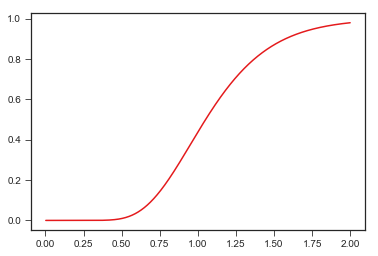

In [14]:
xs = np.linspace(0, 2, 1000)[1:];
plt.plot(xs, [review_model.err_dist.sf(review_model.p_fourstar_threshold/x) for x in xs]);

Similarly, we can get the probability that a paper has a certain value, given that is was awarded 4\* (or not), i.e. $\Pr(v_i = v \mid 4^*)$.

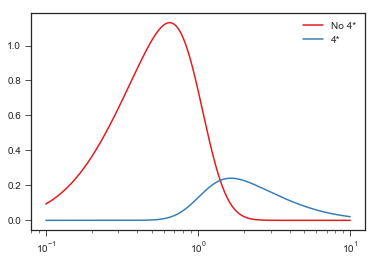

In [15]:
xs = np.logspace(-1, 1, 1000);

plt.plot(xs, review_model.cond_pdf(xs, False), label='No 4*')
plt.plot(xs, review_model.cond_pdf(xs, True), label='4*')
plt.xscale('log')
plt.legend(loc='best');

To resample the proportion of 4\* publications from the REF, we will first sample values for all submitted publications, and then resample the 4\* status of a paper given that sampled value. That yields a certain probability that a 4\* publication will be again awarded 4\*, or similarly, that a publication that was not awarded 4\* will again not be awarded 4\*.

In [16]:
(review_model.accuracy(fourstar=False), # No 4*
 review_model.accuracy(fourstar=True)) # 4*

(0.752986343038826, 0.9448475366753862)

We have now set a `mu_value` ourselves, but we can also infer this value given a certain `p_fourstar_threshold` and `sigma2_err` based on the observed proportion of 4\* publications `pp_fourstar`.

In [17]:
pp_fourstar = 0.2
review_model = ReviewModel.MuValueFromFourStarProportion(
                    pp_fourstar=pp_fourstar, 
                    p_fourstar_threshold=1, 
                    sigma2_err=0.1)

We can now resample 4\* (and non-4\*) publications, and you will see that the resampled proportion of fourstar publications will be around the empirical `pp_fourstar`.

In [18]:
n = 100

n_fourstar = int(np.floor(n*pp_fourstar));
n_nostar = int(n - n_fourstar);

sample_fourstar = review_model.cond_sample_fourstar(n_fourstar, fourstar=True);
sample_nostar = review_model.cond_sample_fourstar(n_nostar, fourstar=False);
sample_pp_fourstar = np.hstack([sample_fourstar, sample_nostar]).mean()
print(sample_pp_fourstar)

0.21


Let us put this in a function

In [19]:
def resample(n, pp_fourstar, p_fourstar_threshold, sigma2_err):
  n_fourstar = int(np.floor(n*pp_fourstar));
  n_nostar = int(n - n_fourstar);
  review_model = ReviewModel.MuValueFromFourStarProportion(pp_fourstar, 
                                        p_fourstar_threshold, 
                                        sigma2_err=sigma2_err);
  
  sample_fourstar = review_model.cond_sample_fourstar(n_fourstar, fourstar=True);
  sample_nostar = review_model.cond_sample_fourstar(n_nostar, fourstar=False);
  return np.hstack([sample_fourstar, sample_nostar]).mean()

We can then resample the values for all institutions and units of assessments.

In [20]:
df['FourStar_resampled'] = df.apply(lambda row: resample(row['n_submission'], row['FourStar'], 
                                                         p_fourstar_threshold=1, sigma2_err=1), axis=1);
df['FourStar_n_resampled'] = df['FourStar_resampled']*df['n_submission']

We can then calculate correlation with the resampled 4\* values.

In [21]:
grp_df = df.groupby(['UOA', 'UnitOfAssessment'])
                        
corr_size_indep = grp_df[['FourStar_resampled', 'FourStar']].corr()
corr_size_indep = corr_size_indep.xs('FourStar', axis=0, level=2)['FourStar_resampled']

corr_size_dep = grp_df[['FourStar_n_resampled', 'FourStar_n']].corr()
corr_size_dep = corr_size_dep.xs('FourStar_n', axis=0, level=2)['FourStar_n_resampled']

mapd_df = grp_df.apply(
    lambda grp: mapd(grp['FourStar_n_resampled'], grp['FourStar_n']))

mad_df = grp_df.apply(
    lambda grp: mad(grp['FourStar_resampled'], grp['FourStar']))

corr_resampled_df = pd.DataFrame({'size_independent': corr_size_indep, 
                                  'size_dependent': corr_size_dep,
                                  'mapd': mapd_df,
                                  'mad': mad_df})

pd.merge(corr_df, corr_resampled_df, left_index=True, right_index=True, 
         suffixes=('_empirical', '_resampled'))

,,size_independent_empirical,size_dependent_empirical,mapd_empirical,mad_empirical,size_independent_resampled,size_dependent_resampled,mapd_resampled,mad_resampled
UOA,UnitOfAssessment,,,,,,,,
1,Clinical Medicine,0.86,0.98,0.15,0.03,0.95,1.00,0.06,0.02
2,"Public Health, Health Services and Primary Care",0.83,0.98,0.16,0.03,0.92,0.99,0.13,0.03
3,"Allied Health Professions, Dentistry, Nursing and Pharmacy",0.54,0.95,0.26,0.05,0.91,0.99,0.15,0.03
4,"Psychology, Psychiatry and Neuroscience",0.79,0.96,0.27,0.04,0.97,1.00,0.14,0.02
5,Biological Sciences,0.69,0.98,0.32,0.09,0.97,1.00,0.08,0.02
6,"Agriculture, Veterinary and Food Science",0.68,0.96,0.27,0.05,0.92,0.98,0.17,0.03
7,Earth Systems and Environmental Sciences,0.80,0.93,0.25,0.03,0.96,0.99,0.09,0.02
8,Chemistry,0.83,0.94,0.23,0.04,0.95,0.99,0.14,0.03
9,Physics,0.86,0.98,0.12,0.03,0.80,0.99,0.08,0.01


Finally, we can repeat the previous bootstrapping many times to get an idea of possible outcomes.

<div class="alert alert-warning" role="alert">
<b>Warning</b>: This may take quite some time to execute.
</div>

In [22]:
replications = 1000
corr_resampled_dfs = []
for idx in range(replications):
    df['FourStar_resampled'] = df.apply(lambda row: resample(row['n_submission'], row['FourStar'], 
                                                             p_fourstar_threshold=1, sigma2_err=1), axis=1);
    df['FourStar_n_resampled'] = df['FourStar_resampled']*df['n_submission']

    grp_df = df.groupby(['UOA', 'UnitOfAssessment'])

    corr_size_indep = grp_df[['FourStar_resampled', 'FourStar']].corr()
    corr_size_indep = corr_size_indep.xs('FourStar', axis=0, level=2)['FourStar_resampled']

    corr_size_dep = grp_df[['FourStar_n_resampled', 'FourStar_n']].corr()
    corr_size_dep = corr_size_dep.xs('FourStar_n', axis=0, level=2)['FourStar_n_resampled']

    mapd_df = grp_df.apply(
        lambda grp: mapd(grp['FourStar_n_resampled'], grp['FourStar_n']))

    mad_df = grp_df.apply(
        lambda grp: mad(grp['FourStar_resampled'], grp['FourStar']))

    corr_resampled_df = pd.DataFrame({'size_independent': corr_size_indep, 
                                      'size_dependent': corr_size_dep,
                                      'mapd': mapd_df,
                                      'mad': mad_df})

    corr_resampled_dfs.append(corr_resampled_df)
    
corr_resampled_df = pd.concat(corr_resampled_dfs)

def perc_025(x):
  return scipy.percentile(x, 0.25);

def perc_975(x):
  return scipy.percentile(x, 97.5);

bootstrap_df = corr_resampled_df.groupby(['UOA', 'UnitOfAssessment']).agg([scipy.median, perc_025, perc_975])
bootstrap_df.columns = ['_'.join(c) for c in bootstrap_df.columns]
bootstrap_corr_df = pd.merge(corr_df, bootstrap_df, left_index=True, right_index=True)
bootstrap_corr_df

,,size_independent,size_dependent,mapd,mad,size_independent_median,size_independent_perc_025,size_independent_perc_975,size_dependent_median,size_dependent_perc_025,size_dependent_perc_975,mapd_median,mapd_perc_025,mapd_perc_975,mad_median,mad_perc_025,mad_perc_975
UOA,UnitOfAssessment,,,,,,,,,,,,,,,,
1,Clinical Medicine,0.86,0.98,0.15,0.03,0.96,0.87,0.98,1.00,0.99,1.00,0.07,0.03,0.10,0.01,7.55e-03,0.02
2,"Public Health, Health Services and Primary Care",0.83,0.98,0.16,0.03,0.94,0.84,0.97,0.99,0.98,1.00,0.11,0.05,0.16,0.02,1.15e-02,0.03
3,"Allied Health Professions, Dentistry, Nursing and Pharmacy",0.54,0.95,0.26,0.05,0.92,0.86,0.94,0.99,0.98,0.99,0.14,0.09,0.18,0.02,1.69e-02,0.03
4,"Psychology, Psychiatry and Neuroscience",0.79,0.96,0.27,0.04,0.96,0.93,0.97,1.00,0.99,1.00,0.13,0.07,0.19,0.02,1.60e-02,0.03
5,Biological Sciences,0.69,0.98,0.32,0.09,0.97,0.95,0.98,1.00,0.99,1.00,0.08,0.04,0.11,0.02,1.13e-02,0.03
6,"Agriculture, Veterinary and Food Science",0.68,0.96,0.27,0.05,0.94,0.86,0.97,0.99,0.97,0.99,0.13,0.05,0.20,0.02,1.00e-02,0.03
7,Earth Systems and Environmental Sciences,0.80,0.93,0.25,0.03,0.94,0.87,0.96,0.98,0.96,0.99,0.12,0.07,0.17,0.02,1.19e-02,0.03
8,Chemistry,0.83,0.94,0.23,0.04,0.96,0.91,0.97,0.99,0.97,0.99,0.12,0.06,0.18,0.02,1.16e-02,0.03
9,Physics,0.86,0.98,0.12,0.03,0.87,0.75,0.93,0.99,0.98,0.99,0.11,0.06,0.17,0.02,1.21e-02,0.03


## References

1. Traag, V.A. & Waltman, L. (2018) Systematic analysis of agreement between metrics and peer review in the UK REF.